# Learning from text

Dataset: The 1000 most recent cycling articles in the Irish Times - starting around the year 2000 and up until last week. It would be easy to scale this to more articles - in fact, 1000 documents is about the minimum needed for a good topic model to be generated.

We are going to use topic modeling to uncover the sub-topics of these articles and thus better understand the range of news coverage. 

In [2]:
# load regular packages
import pandas as pd
import numpy as np
from pprint import pprint
import re, os, operator
import collections 
import matplotlib.pyplot as plt
%matplotlib inline

1. Text processing packages

In [3]:
# nltk - primary NLP package along with 're'
import nltk
from nltk.corpus import stopwords

# spacy - text comprehension package
import spacy

#import sys
#!{sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.2.5/en_core_web_lg-2.2.5.tar.gz --no-deps

# package for counting term usage
from sklearn.feature_extraction.text import CountVectorizer

2. Topic modeling packages

In [4]:
# gensim - topic modeling package
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# pyldavis - plotting package for topic models
import pyLDAvis
from pyLDAvis import gensim as gen

# set link to LDA Mallet java package on computer: http://mallet.cs.umass.edu/download.php
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/',
                  'JAVA_HOME': r'C:/Program Files/Java/jdk1.8.0_271/'})

mallet_path = r'C:\new_mallet\mallet-2.0.8\bin\mallet'

# The data

In [5]:
# Import data

cycle = pd.read_csv("cycle_docs.csv")

cycle.head()

# note the use of abstracts of articles rather than full articles

,Title,Abstract,StoreId,pubdate,pubtitle,year,startPage
0,"[euro]15,000 for cyclist for assault by coach ...",He said [William Murray] started shouting at h...,918697672,"Jan 31, 2012",Irish Times,2012,4
1,A coupling of bicycles,"Sir, - Twice in half an hour Frank McNally (An...",919712610,"Feb 4, 2012",Irish Times,2012,15
2,Schoolboy died after fall from bicycle,"Julie Cooper, who has a holiday home in Allihi...",922429243,"Feb 22, 2012",Irish Times,2012,2
3,&#39;Thirst for vengeance&#39; pushed man to d...,"Garda Danielle Farragher told Elva Duffy, pros...",932562504,"Mar 23, 2012",Irish Times,2012,4
4,Dublin cycling officer loses job after funding...,"He said there were ""more trips made every day ...",911447802,"Dec 17, 2011",Irish Times,2011,3


In [6]:
cycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      1000 non-null   object
 1   Abstract   719 non-null    object
 2   StoreId    1000 non-null   int64 
 3   pubdate    1000 non-null   object
 4   pubtitle   1000 non-null   object
 5   year       1000 non-null   int64 
 6   startPage  1000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


In [6]:
# Create an all_text variable

cycle["all_text"] = cycle["Title"] + cycle["Abstract"]

print('Average all_text length: ' + str(cycle["all_text"].str.split().str.len().mean()))

Average all_text length: 111.13630041724618


In [7]:
# Change all_text to list

cycle1 = cycle['all_text'].values.tolist()

pprint(cycle1[:1])

['[euro]15,000 for cyclist for assault by coach driverHe said [William Murray] '
 'started shouting at him, complaining that he had interfered with his ability '
 'to do his work. Following an exchange of words, Murray shoved his chest up '
 'against his. Mr [Scott Alexander Burns] went around to the front of the '
 'coach and photographed its registration on his mobile phone before taking a '
 'photograph of Murray. Judge Jacqueline Linnane rejected legal submissions by '
 "solicitor Ger O'Herlihy for Bus Eireann that the company was not liable for "
 'an action by an employee on a public footpath which was not associated with '
 'his duties as a driver.']


# Textual data pre-processing

In [8]:
# Basic cleaning

cycle2 = []

for sentence in range(0, len(cycle1)):
    
    # Add spaces if two words appear to be concatenated by mistake
    p_cycle = re.sub(r'(\w)([A-Z])', r'\1 \2', str(cycle1[sentence]))
    
    # Remove all the special characters
    p_cycle = re.sub(r'\W', ' ', p_cycle)

    # remove all numbers
    p_cycle = re.sub(r'\d+','', p_cycle)
    
    # Remove single characters from the start
    p_cycle = re.sub(r'\^[a-zA-Z]\s+', ' ', p_cycle) 

    # Substituting multiple spaces with single space
    p_cycle = re.sub(r'\s+', ' ', p_cycle, flags=re.I)

    # Remove prefixed 'b', if present
    p_cycle = re.sub(r'^b\s+', '', p_cycle)
    

    cycle2.append(p_cycle)
    
pprint(cycle2[:1])

[' euro for cyclist for assault by coach driver He said William Murray started '
 'shouting at him complaining that he had interfered with his ability to do '
 'his work Following an exchange of words Murray shoved his chest up against '
 'his Mr Scott Alexander Burns went around to the front of the coach and '
 'photographed its registration on his mobile phone before taking a photograph '
 'of Murray Judge Jacqueline Linnane rejected legal submissions by solicitor '
 'Ger O Herlihy for Bus Eireann that the company was not liable for an action '
 'by an employee on a public footpath which was not associated with his duties '
 'as a driver ']


In [9]:
# Change strings to bag-of-words

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

cycle_words = list(sent_to_words(cycle2))

print(cycle_words[:1])

[['euro', 'for', 'cyclist', 'for', 'assault', 'by', 'coach', 'driver', 'he', 'said', 'william', 'murray', 'started', 'shouting', 'at', 'him', 'complaining', 'that', 'he', 'had', 'interfered', 'with', 'his', 'ability', 'to', 'do', 'his', 'work', 'following', 'an', 'exchange', 'of', 'words', 'murray', 'shoved', 'his', 'chest', 'up', 'against', 'his', 'mr', 'scott', 'alexander', 'burns', 'went', 'around', 'to', 'the', 'front', 'of', 'the', 'coach', 'and', 'photographed', 'its', 'registration', 'on', 'his', 'mobile', 'phone', 'before', 'taking', 'photograph', 'of', 'murray', 'judge', 'jacqueline', 'linnane', 'rejected', 'legal', 'submissions', 'by', 'solicitor', 'ger', 'herlihy', 'for', 'bus', 'eireann', 'that', 'the', 'company', 'was', 'not', 'liable', 'for', 'an', 'action', 'by', 'an', 'employee', 'on', 'public', 'footpath', 'which', 'was', 'not', 'associated', 'with', 'his', 'duties', 'as', 'driver']]


# Preparing the Document-Term-Matrix

Bigrams or unigrams? Bigrams give more context but require extra work and are not as replicable. Unigrams keep each persons decisions to a minimum which is good for replicability but not as precise.

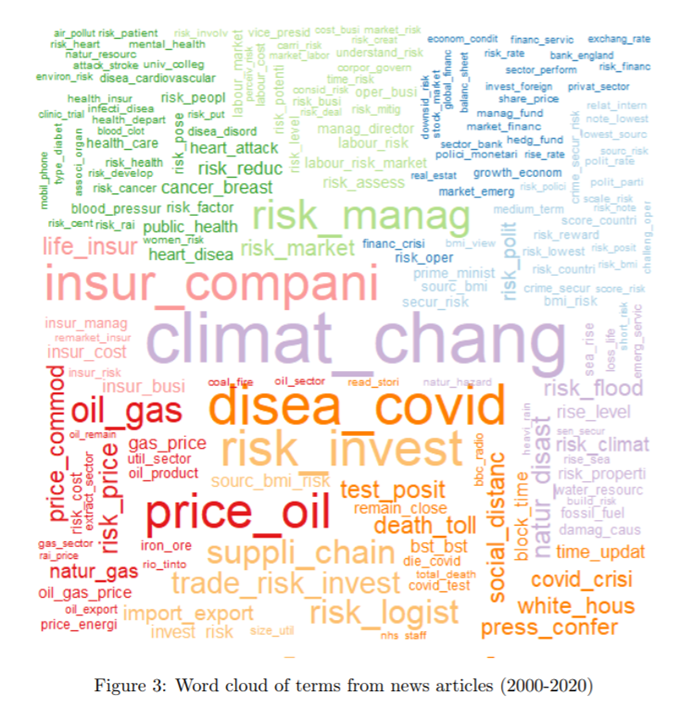

In [10]:
# Reducing the term count (setup)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

stop_words = stopwords.words('english')
stop_words.extend(['cycle', 'cyclist','say', 'bike', 'road', 'cycling',
                  'bicycle', 'year', 'go', 'would', 'take', 'use', 'see',
                  'also', 'get', 'come', 'could', 'know', 'tell', 'may'])

In [11]:
# Reducing the term count (implement)

cycle_lemma = lemmatization(cycle_words, allowed_postags=['NOUN'])

cycle_lemma = remove_stopwords(cycle_lemma)

print(cycle_lemma[:1])

[['assault', 'coach', 'driver', 'ability', 'work', 'exchange', 'word', 'chest', 'front', 'coach', 'registration', 'phone', 'photograph', 'submission', 'solicitor', 'company', 'action', 'employee', 'footpath', 'duty', 'driver']]


In [ ]:
# Inspect most frequent terms

def detoken(texts):
    """detokenizer"""
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join(s for s in sent))
    return texts_out

cycle_lemma_test = detoken(cycle_lemma)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cycle_lemma_test)
freq = np.ravel(X.sum(axis=0)) 

vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq))

# Save all terms as CSV file to inspect all

with open('term_dict.csv', 'w', encoding='utf-8') as f:
    for key in fdist.keys():
        f.write("%s,%s\n"%(key,fdist[key]))

In [12]:
# Create a document-term-matrix (DTM)

# Create Dictionary
id2word = Dictionary(cycle_lemma)
print("Length of initial dictionary is: ", (len(id2word)))

id2word.filter_extremes(no_below=5, no_above=0.5)
print("Length of reduced dictionary is: ", (len(id2word)))

# Create Corpus
texts = cycle_lemma

# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts]

# View
print(corpus1[:1])
print(id2word)

Length of initial dictionary is:  3158
Length of reduced dictionary is:  633
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
Dictionary(633 unique tokens: ['ability', 'action', 'assault', 'coach', 'company']...)


In [13]:
# Find low term documents and remove (less than 3 terms per document)

# Convert corpus to a numpy matrix
numpy_matrix = gensim.matutils.corpus2dense(corpus1, num_terms=len(id2word)) # adjust based on length of dictionary

# Create a filtered matrix that removes docs with less than 3 terms
n_matrix2 = numpy_matrix[:, (numpy_matrix != 0).sum(axis=0) > 2]

# Convert matrix back to a corpus
corpus = gensim.matutils.Dense2Corpus(n_matrix2)

# Confirm change has been made
print(len(corpus1)) # original corpus
print(len(corpus)) # new corpus

1000
686


## Topic modeling 

Uncovering the hidden or latent topics across a set of documents. 

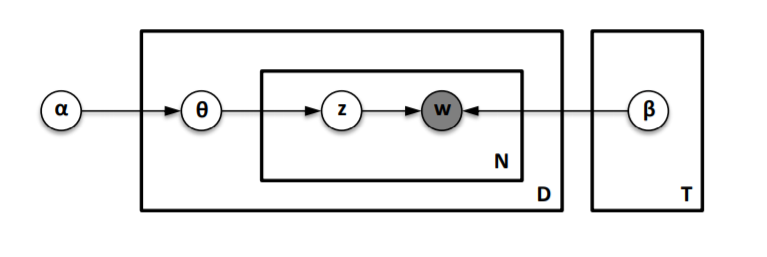

In [25]:
# The topic models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    alpha = [0.1, 1, 10]
    random_seed = [32, 64]
    coherence_values = []
    model_list = []
    output_list = []
    for num_topics in range(start, limit, step):
        for a in alpha:
            for r in random_seed:
                model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=r, workers=3, alpha=a)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
                model_output ={'alpha': a, 'random_seed': r, 'coherence': coherencemodel.get_coherence(), 'num_topics': num_topics}
                output_list.append(model_output)

    return model_list, coherence_values, output_list

model_list, coherence_values, output_list = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=4, limit=18, step=2)


In [28]:
# Inspect the models

output_list_descending = sorted(output_list, key=lambda d: d['coherence'], reverse=True)
pprint(output_list_descending)

[{'alpha': 0.1,
  'coherence': 0.5052945987204869,
  'num_topics': 4,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.47960956445975267,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 1,
  'coherence': 0.4677051545137552,
  'num_topics': 4,
  'random_seed': 32},
 {'alpha': 1,
  'coherence': 0.46534954513324167,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 1,
  'coherence': 0.4608595367031349,
  'num_topics': 6,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.46043395109799395,
  'num_topics': 6,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.4599796761997914,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.4569617959222974,
  'num_topics': 6,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.45055398666482804,
  'num_topics': 6,
  'random_seed': 32},
 {'alpha': 0.1,
  'coherence': 0.4460079071456874,
  'num_topics': 8,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.4426308078862822,
  'num_topics': 4,
  'random_seed'

In [29]:
# Best Model (1) - 4 topics (random_state=32, alpha=0.1)

ldamallet4 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word, random_seed=32, alpha=0.1, workers=3)

# Show Topics
pprint(ldamallet4.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet4 = CoherenceModel(model=ldamallet4, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet4 = coherence_model_ldamallet4.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet4)

[(0,
  [('city', 0.04939063502245029),
   ('car', 0.027902501603592048),
   ('scheme', 0.023733162283515075),
   ('lane', 0.02052597819114817),
   ('transport', 0.020205259781911483),
   ('route', 0.01892238614496472),
   ('people', 0.01860166773572803),
   ('number', 0.01796023091725465),
   ('cent', 0.01603592046183451),
   ('parking', 0.012187299550994226)]),
 (1,
  [('death', 0.03564608529598982),
   ('man', 0.03500954805856143),
   ('collision', 0.031190324633991087),
   ('car', 0.028007638446849142),
   ('truck', 0.021642266072565246),
   ('court', 0.020369191597708464),
   ('yesterday', 0.019096117122851686),
   ('lock', 0.01782304264799491),
   ('crash', 0.01782304264799491),
   ('child', 0.01718650541056652)]),
 (2,
  [('team', 0.027359437751004016),
   ('tour', 0.02459839357429719),
   ('race', 0.023092369477911646),
   ('rider', 0.019327309236947792),
   ('time', 0.019327309236947792),
   ('day', 0.019076305220883535),
   ('sport', 0.01430722891566265),
   ('world', 0.014056

In [30]:
# Best Model (2) - 8 topics (random_state=64, alpha=0.1)

ldamallet8 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word, random_seed=64, alpha=0.1, workers=3)

# Show Topics
pprint(ldamallet8.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet8 = CoherenceModel(model=ldamallet8, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet8 = coherence_model_ldamallet8.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet8)

[(0,
  [('route', 0.0350597609561753),
   ('traffic', 0.030278884462151396),
   ('cent', 0.02151394422310757),
   ('government', 0.02151394422310757),
   ('trail', 0.020717131474103586),
   ('accident', 0.020717131474103586),
   ('transport', 0.0199203187250996),
   ('fine', 0.0199203187250996),
   ('limit', 0.0199203187250996),
   ('infrastructure', 0.016733067729083666)]),
 (1,
  [('team', 0.053562653562653564),
   ('tour', 0.04815724815724816),
   ('race', 0.040294840294840296),
   ('rider', 0.03341523341523341),
   ('sport', 0.023095823095823097),
   ('time', 0.02113022113022113),
   ('stage', 0.020147420147420148),
   ('world', 0.0171990171990172),
   ('day', 0.015233415233415233),
   ('event', 0.014742014742014743)]),
 (2,
  [('man', 0.04180064308681672),
   ('death', 0.03938906752411576),
   ('collision', 0.03778135048231511),
   ('car', 0.03536977491961415),
   ('driver', 0.03295819935691318),
   ('court', 0.02572347266881029),
   ('truck', 0.02491961414790997),
   ('yesterday'

In [31]:
# convert preferred models from LDA Mallet back to Gensim LDA

# 4 topics
lda4 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet4, gamma_threshold=0.001, iterations=50)

pprint(lda4.print_topics())
doc_lda4 = lda4[corpus]

coherence_model_lda4 = CoherenceModel(model=lda4, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda4 = coherence_model_lda4.get_coherence()

# 8 topics
lda8 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet8, gamma_threshold=0.001, iterations=50)

pprint(lda8.print_topics())
doc_lda8 = lda8[corpus]

coherence_model_lda8 = CoherenceModel(model=lda8, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda8 = coherence_model_lda8.get_coherence()


[(0,
  '0.049*"city" + 0.028*"car" + 0.024*"scheme" + 0.021*"lane" + '
  '0.020*"transport" + 0.019*"route" + 0.019*"people" + 0.018*"number" + '
  '0.016*"cent" + 0.012*"parking"'),
 (1,
  '0.036*"death" + 0.035*"man" + 0.031*"collision" + 0.028*"car" + '
  '0.022*"truck" + 0.020*"court" + 0.019*"yesterday" + 0.018*"lock" + '
  '0.018*"crash" + 0.017*"child"'),
 (2,
  '0.027*"team" + 0.025*"tour" + 0.023*"race" + 0.019*"rider" + 0.019*"time" + '
  '0.019*"day" + 0.014*"sport" + 0.014*"world" + 0.011*"stage" + '
  '0.011*"event"'),
 (3,
  '0.042*"driver" + 0.034*"lane" + 0.031*"traffic" + 0.031*"motorist" + '
  '0.029*"helmet" + 0.027*"safety" + 0.025*"light" + 0.024*"pedestrian" + '
  '0.021*"car" + 0.018*"city"')]

Coherence Score lda4:  0.5052945987204869
[(0,
  '0.035*"route" + 0.030*"traffic" + 0.022*"cent" + 0.022*"government" + '
  '0.021*"trail" + 0.021*"accident" + 0.020*"transport" + 0.020*"fine" + '
  '0.020*"limit" + 0.017*"infrastructure"'),
 (1,
  '0.054*"team" + 0.048*"t

In [32]:
# Visualise with pyLDAvis - 10 topics model

pyLDAvis.enable_notebook()
vis = gen.prepare(lda4, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.034560  0.294226       1        1  35.342217
0     -0.247380 -0.012053       2        1  27.820525
3     -0.076308 -0.187268       3        1  22.785949
1      0.289128 -0.094906       4        1  14.051309, topic_info=        Term        Freq       Total Category  logprob  loglift
31      city  204.000000  204.000000  Default  30.0000  30.0000
5     driver  134.000000  134.000000  Default  29.0000  29.0000
63      team  110.000000  110.000000  Default  28.0000  28.0000
19       man   84.000000   84.000000  Default  27.0000  27.0000
109     lane  154.000000  154.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
173  station   15.314675   34.666357   Topic4  -4.6514   1.1455
240   family   15.314675   36.579885   Topic4  -4.6514   1.0918
48      time   18.377610  140.553941   Topic4  -4.4691  -0.0720
105  vehicle   16.335653   68.970074   Topic4  -4.5869   0.5221
32       day   17.356631  130.058424   Topic4  -4.5263  -0.0516

[292 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
200       1  0.060828   accident
200       3  0.532248   accident
200       4  0.410591   accident
129       4  0.979453     advice
581       1  0.987528        age
...     ...       ...        ...
11        3  0.111114       work
336       1  0.936822      world
336       3  0.065742      world
165       1  0.393067  yesterday
165       4  0.609254  yesterday

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [33]:
# Visualise with pyLDAvis - 8 topics model

pyLDAvis.enable_notebook()
vis = gen.prepare(lda8, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.099487 -0.077988       1        1  18.047013
4      0.152343 -0.024009       2        1  16.610456
7     -0.261230  0.019759       3        1  14.993402
3     -0.053383  0.191667       4        1  14.562208
0     -0.153824  0.108311       5        1  11.192899
2     -0.136394 -0.094793       6        1  11.038176
5      0.072642 -0.312978       7        1   7.936698
6      0.280359  0.190031       8        1   5.619147, topic_info=       Term        Freq       Total Category  logprob  loglift
31     city  206.000000  206.000000  Default  30.0000  30.0000
109    lane  154.000000  154.000000  Default  29.0000  29.0000
63     team  110.000000  110.000000  Default  28.0000  28.0000
157    tour   99.000000   99.000000  Default  27.0000  27.0000
171  helmet   84.000000   84.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
48     time   13.580673  140.372656   Topic8  -3.8550   0.5433
335   point    9.402004   51.088424   Topic8  -4.2228   1.1864
83   people   10.446671  130.813017   Topic8  -4.1174   0.3515
32      day    8.357337  129.768080   Topic8  -4.3406   0.1364
81   number    7.312670   99.747576   Topic8  -4.4741   0.2660

[457 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.987832    ability
304       4  0.966747     access
512       2  0.488561  accessory
512       8  0.488561  accessory
200       2  0.107649   accident
...     ...       ...        ...
336       2  0.296342      world
336       7  0.049390      world
336       8  0.065854      world
165       1  0.395004  yesterday
165       6  0.592506  yesterday

[724 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 8, 4, 1, 3, 6, 7])

In [45]:
# Assign topic percentages to documents

def format_topics_docs(ldamodel=lda8, corpus=corpus1, texts=cycle1):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_docs_keywords = format_topics_docs(ldamodel=lda8, corpus=corpus1, texts=cycle1)

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4056,"team, tour, race, rider, sport, time, stage, w...","[euro]15,000 for cyclist for assault by coach ..."
1,1,7.0,0.5198,"lane, driver, traffic, car, city, motorist, pe...","A coupling of bicyclesSir, - Twice in half an ..."
2,2,5.0,0.4821,"helmet, child, safety, risk, people, injury, s...",Schoolboy died after fall from bicycleJulie Co...
3,3,2.0,0.8389,"man, death, collision, car, driver, court, tru...",&#39;Thirst for vengeance&#39; pushed man to d...
4,4,0.0,0.3537,"route, traffic, cent, government, trail, accid...",Dublin cycling officer loses job after funding...
5,5,0.0,0.4350,"route, traffic, cent, government, trail, accid...",Time to back-pedal on cycling officerIt's clea...
6,6,1.0,0.9857,"team, tour, race, rider, sport, time, stage, w...",Cycling officer gets jobs reprieveThere was co...
7,7,4.0,0.5389,"day, people, time, wheel, woman, trip, km, wor...",Service for boy killed after fall from bicycle...
8,8,6.0,0.5371,"lock, tax, theft, employer, insurance, phone, ...","The bicycle thieves move up a gear""If most peo..."
9,9,3.0,0.3555,"city, scheme, car, transport, number, people, ...",iPhone attracts application of new breed of bi...


In [46]:
# Convert to a final dataframe

cycle_topic = pd.merge(cycle, df_dominant_topic, left_on='all_text', right_on='Text', how='inner')

cycle_topic = cycle_topic[cycle_topic['all_text'].notna()]

cycle_topic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 0 to 79679
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               719 non-null    object 
 1   Abstract            719 non-null    object 
 2   StoreId             719 non-null    int64  
 3   pubdate             719 non-null    object 
 4   pubtitle            719 non-null    object 
 5   year                719 non-null    int64  
 6   startPage           719 non-null    int64  
 7   all_text            719 non-null    object 
 8   Document_No         719 non-null    int64  
 9   Dominant_Topic      719 non-null    float64
 10  Topic_Perc_Contrib  719 non-null    float64
 11  Keywords            719 non-null    object 
 12  Text                719 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 78.6+ KB


In [49]:
# Chart topic proportions in early and recent times

x = {2015: 2015, 2016: 2015, 2017: 2015,
    2018: 2020, 2019: 2020, 2020: 2020,
    2021: 2020}

cycle_topic['year_dum'] = cycle_topic['year'].map(x)

dom_topic = cycle_topic.groupby(['year_dum', 'Dominant_Topic']).agg({'Dominant_Topic': 'count'})
dom_topic_pct = dom_topic.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

cy_top = dom_topic_pct.unstack(level=-1)

cy_top

Dominant_Topic                                              \
Dominant_Topic            0.0        1.0        2.0        3.0        4.0   
year_dum                                                                    
2015.0              11.363636  18.181818  17.727273   9.545455  15.454545   
2020.0               6.976744  11.627907  16.279070  13.953488  32.558140   

                                               
Dominant_Topic       5.0       6.0        7.0  
year_dum                                       
2015.0          5.909091  4.545455  17.272727  
2020.0          9.302326       NaN   9.302326

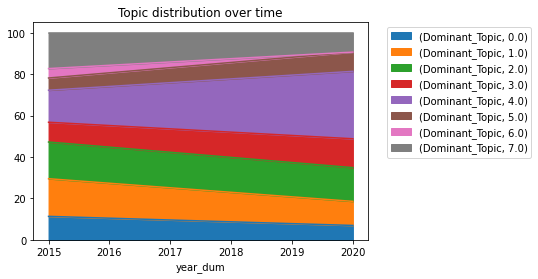

In [52]:
cy_top.plot(kind='area', stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Topic distribution over time')
plt.show()